## Synthesised from
1. https://www.youtube.com/watch?v=moydeKyFF6M
2. https://github.com/ZahraBenslimane/SoundSourceSeparation_usingNMF

## Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import pickle
import warnings
warnings.filterwarnings('ignore')

## Examining original audio file

In [5]:
audio_file = 'audio_files/piano_with_rain.mp3'
sampling_rate = 22050
duration = 24
original_audio, _ = librosa.load(audio_file,
                                 sr=sampling_rate, duration=duration)
ipd.Audio(original_audio, rate=sampling_rate)

In [6]:
original_audio

array([-0.00379917, -0.00205804,  0.00812829, ..., -0.01931162,
       -0.01874658, -0.01708545], dtype=float32)

In [7]:
print(f"Total number of amplitudes: {len(original_audio)}")
print(f"amplitudes/second times seconds: {sampling_rate * duration}")

Total number of amplitudes: 529200
amplitudes/second times seconds: 529200


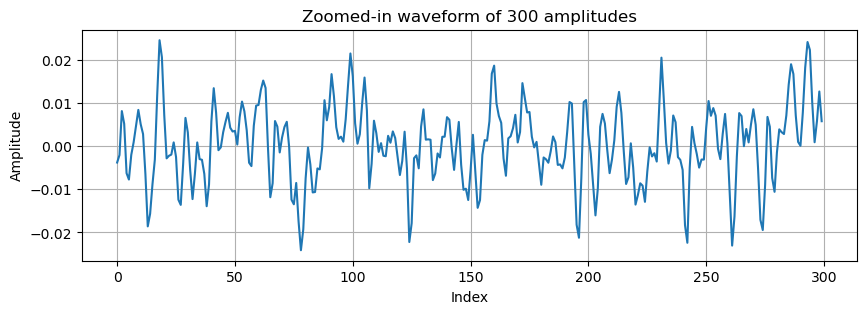

In [8]:
# Zoom into 300 amplitudes
plt.figure(figsize=(10, 3))
plt.plot(original_audio[0:300])
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Zoomed-in waveform of 300 amplitudes")
plt.grid(True)
plt.show()

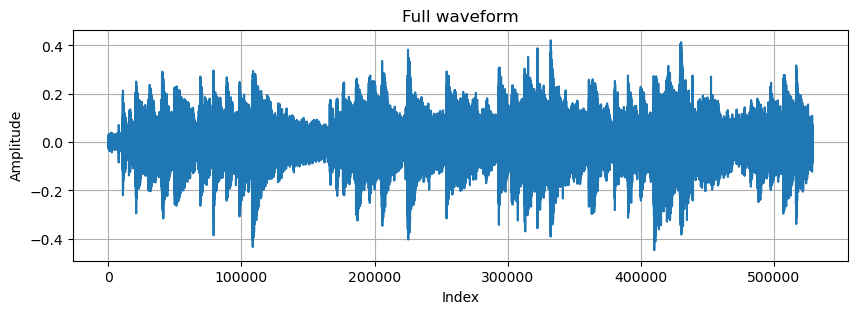

In [9]:
# All amplitudes
plt.figure(figsize=(10, 3))
plt.plot(original_audio)
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Full waveform")
plt.grid(True)
plt.show()

## Short-Time Fourier Transform (STFT)

In [11]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

In [12]:
STFT_matrix = librosa.stft(original_audio,
                           n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

In [13]:
STFT_matrix

array([[ 2.4870578e-02+0.00000000e+00j, -2.2519279e-02+0.00000000e+00j,
         8.4853061e-03+0.00000000e+00j, ...,
        -9.9838895e-01+0.00000000e+00j,  4.7751361e-01+0.00000000e+00j,
        -2.3990834e-01+0.00000000e+00j],
       [-2.6019601e-02+3.69908451e-03j,  3.9364129e-02+2.19116341e-02j,
         1.9733185e-02+1.29547585e-02j, ...,
         5.9061033e-01-1.82315648e-01j, -5.5252600e-01+5.75064898e-01j,
         1.5969132e-01-5.63445568e-01j],
       [ 4.1979965e-02-1.40122352e-02j, -5.5598211e-02-1.52811725e-02j,
        -1.0928916e-01-1.42181991e-02j, ...,
         5.6396533e-02-6.99056312e-02j,  4.4765308e-01-9.17922780e-02j,
        -1.5445930e-01+8.75976235e-02j],
       ...,
       [ 3.6311842e-04+4.34754984e-05j,  3.7637778e-07+2.12790860e-06j,
         2.9711734e-06-9.31837917e-07j, ...,
        -3.1916109e-06+8.70142856e-07j,  1.5436727e-06+4.25611870e-06j,
        -2.4352819e-03-1.65303529e-03j],
       [-3.6366677e-04-2.19618851e-05j, -1.0433538e-06+2.81303496e-0

## Separating STFT into Phase & Magnitude Spectrograms

In [15]:
phase_spectrogram = np.angle(STFT_matrix)

In [16]:
magnitude_spectrogram = np.abs(STFT_matrix)

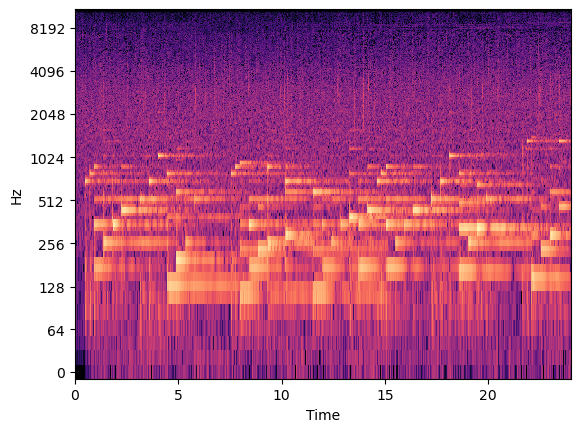

In [17]:
librosa.display.specshow(librosa.amplitude_to_db(magnitude_spectrogram,
                                                 ref=np.max),
                         sr=sampling_rate, hop_length=HOP_LENGTH,
                         x_axis='time', y_axis='log')

## Applying Multiplicative Update Rules for Non-negative Matrix Factorisation

In [19]:
with open("random_state.pkl", "rb") as f:
    random_state = pickle.load(f)
np.random.set_state(random_state)

In [20]:
def MultiplicativeUpdate(V, S, beta, N):
    F, T = np.shape(V)
    W = np.abs(np.random.normal(loc=0, scale = 2.5, size=(F,S)))    
    H = np.abs(np.random.normal(loc=0, scale = 2.5, size=(S,T)))

    for _ in range(N):
        H = ( H * ( W.T @ ( V * ( (W @ H)**(beta-2) ) ) )
                / ( W.T @ ( (W @ H)**(beta-1) ) + 10e-10 ) )
        
        W = ( W * ( ( V * ( (W @ H)**(beta-2) ) ) @ H.T )
                / ( ( (W @ H)**(beta-1) ) @ H.T + 10e-10 ) )
    
    return W, H

In [21]:
W, H = MultiplicativeUpdate(V=magnitude_spectrogram, S=14, beta=1, N=5000)

## Generating new audio file from filtered piano notes (basic sound sources)

In [23]:
piano_notes = [0,1,2,4,6,11,13]

In [24]:
filtered_magnitudeSpectrogram = W[:, piano_notes] @ H[piano_notes, :]

In [25]:
filtered_STFTmatrix = (filtered_magnitudeSpectrogram
                       * np.exp(1j * phase_spectrogram))

In [26]:
filtered_audio = librosa.istft(filtered_STFTmatrix,
                               n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

In [27]:
ipd.Audio(filtered_audio, rate=sampling_rate)

In [28]:
ipd.Audio(original_audio, rate=sampling_rate)